## 1) Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sqlalchemy import create_engine

import warnings

from scipy.stats.mstats import winsorize
from scipy.stats import zscore
from scipy.stats import jarque_bera
from scipy.stats import normaltest

warnings.filterwarnings('ignore')

## 2) First, load the dataset.

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [4]:
life_df.columns = life_df.columns.str.strip()
life_df.columns = life_df.columns.str.replace(' +', '_')

In [5]:
life_df.head()

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [6]:
life_df.describe()

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under-five_deaths,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## 3) Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [7]:
life_df.isnull()

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2934,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2935,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2936,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
life_df.isna().sum()*100/life_df.isna().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life_expectancy                     0.340368
Adult_Mortality                     0.340368
infant_deaths                       0.000000
Alcohol                             6.603131
percentage_expenditure              0.000000
Hepatitis_B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five_deaths                   0.000000
Polio                               0.646698
Total_expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness_1-19_years                 1.157250
thinness_5-9_years                  1.157250
Income_composition_of_resources     5.684139
Schooling                           5.547992
dtype: flo

In [9]:
life_df

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


## Measles column has values > 1000 (cases per 1000), so remove it

In [10]:
life_df = life_df.drop(columns = ['Measles'])

## Columns with < 6% n/a, should be safe to delete n/a rows

In [11]:
cols = ['Life_expectancy', 'Adult_Mortality', 'BMI', 
        'Polio', 'Diphtheria', 'thinness_1-19_years', 
        'thinness_5-9_years', 'Income_composition_of_resources', 'Schooling']

life_df = life_df.dropna(subset=cols)

In [12]:
life_df.isna().sum()*100/life_df.isna().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life_expectancy                     0.000000
Adult_Mortality                     0.000000
infant_deaths                       0.000000
Alcohol                             6.085044
percentage_expenditure              0.000000
Hepatitis_B                        17.631965
BMI                                 0.000000
under-five_deaths                   0.000000
Polio                               0.000000
Total_expenditure                   6.304985
Diphtheria                          0.000000
HIV/AIDS                            0.000000
GDP                                10.190616
Population                         17.741935
thinness_1-19_years                 0.000000
thinness_5-9_years                  0.000000
Income_composition_of_resources     0.000000
Schooling                           0.000000
dtype: float64

## Replace other n/a values with the column mean

In [13]:
life_df["Alcohol"] = life_df["Alcohol"].fillna(life_df["Alcohol"].mean())
life_df["Hepatitis_B"] = life_df["Hepatitis_B"].fillna(life_df["Hepatitis_B"].mean())
life_df["Total_expenditure"] = life_df["Total_expenditure"].fillna(life_df["Total_expenditure"].mean())

## Replace n/a values in GDP and Population with 0

In [14]:
life_df["GDP"] = life_df["GDP"].fillna(0)
life_df["Population"] = life_df["Population"].fillna(0)

In [15]:
life_df.isna().sum()*100/life_df.isna().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life_expectancy                    0.0
Adult_Mortality                    0.0
infant_deaths                      0.0
Alcohol                            0.0
percentage_expenditure             0.0
Hepatitis_B                        0.0
BMI                                0.0
under-five_deaths                  0.0
Polio                              0.0
Total_expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness_1-19_years                0.0
thinness_5-9_years                 0.0
Income_composition_of_resources    0.0
Schooling                          0.0
dtype: float64

In [16]:
life_df

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,BMI,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,27.1,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,26.7,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,26.3,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,25.9,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [17]:
life_df.shape

(2728, 21)

## Look at groupings

In [18]:
life_df['Country'].value_counts()

Russian Federation      16
Djibouti                16
Cyprus                  16
Benin                   16
United Arab Emirates    16
                        ..
Zimbabwe                16
Uzbekistan              16
Bahrain                 16
Timor-Leste             14
Montenegro              10
Name: Country, Length: 171, dtype: int64

In [19]:
life_df['Year'].value_counts()

2015    171
2013    171
2011    171
2009    171
2007    171
2014    171
2012    171
2010    171
2008    171
2006    171
2005    170
2003    170
2004    170
2002    170
2001    169
2000    169
Name: Year, dtype: int64

In [20]:
life_df['Status'].value_counts()

Developing    2264
Developed      464
Name: Status, dtype: int64

## Find and handle outliers

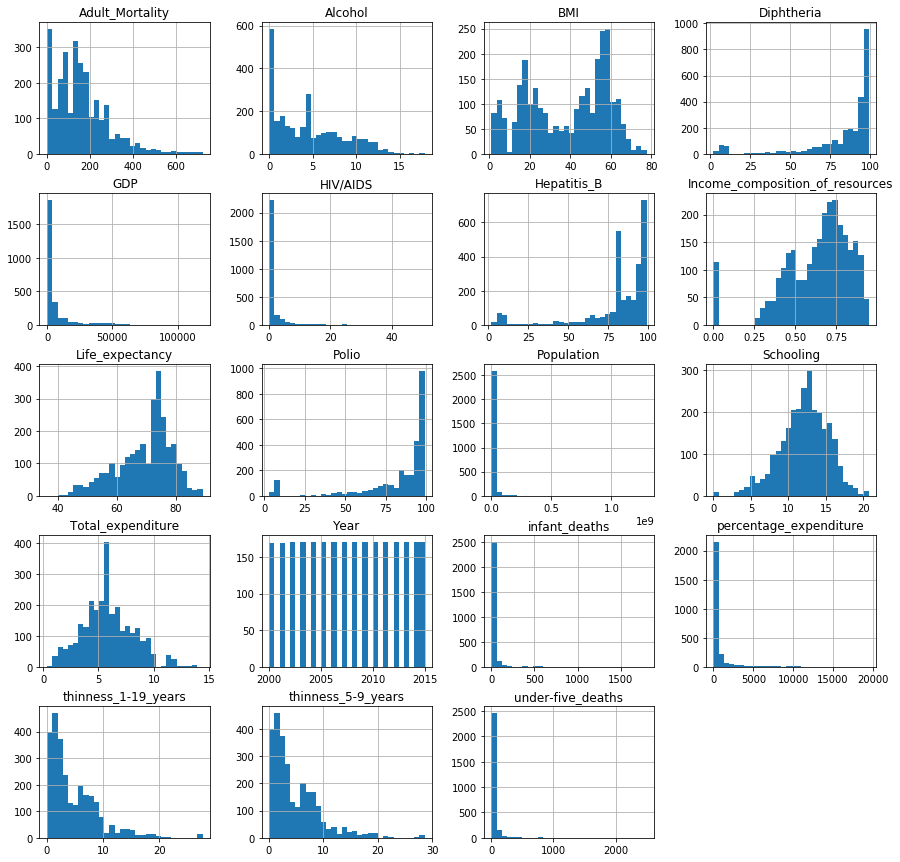

In [21]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_df = life_df.select_dtypes(include=numerics)
numeric_df.hist(bins=30, figsize=(15, 15))
plt.show()

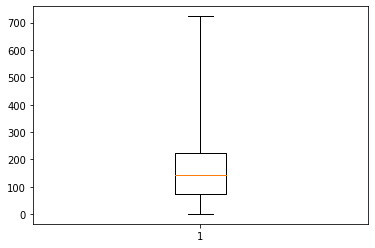

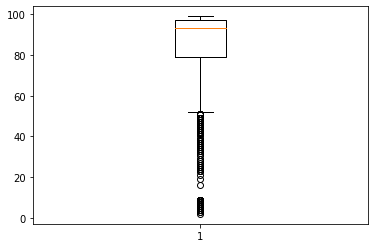

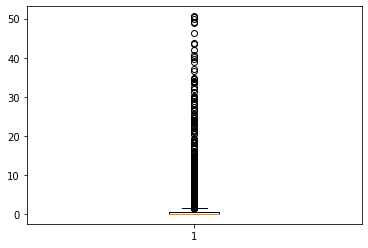

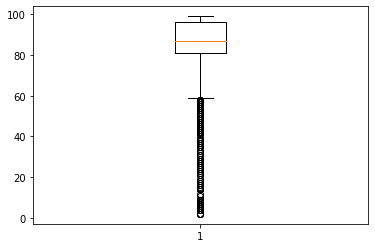

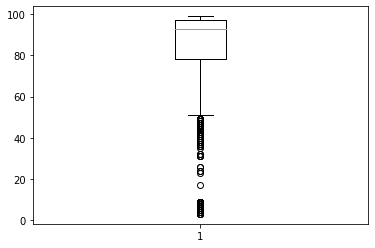

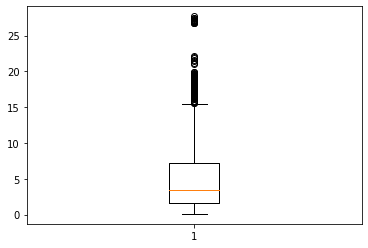

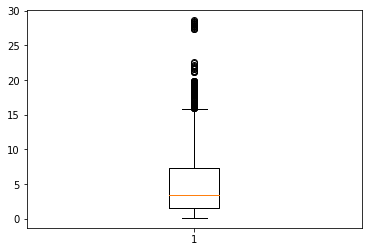

In [22]:
plt.boxplot(life_df['Adult_Mortality'], whis=300)
plt.show()
plt.boxplot(life_df['Diphtheria'])
plt.show()
plt.boxplot(life_df['HIV/AIDS'])
plt.show()
plt.boxplot(life_df['Hepatitis_B'])
plt.show()
plt.boxplot(life_df['Polio'])
plt.show()
plt.boxplot(life_df['thinness_1-19_years'])
plt.show()
plt.boxplot(life_df['thinness_5-9_years'])
plt.show()

## Z-scores to find and count outliers

In [23]:
z_scores = zscore(life_df["Adult_Mortality"])
outliers = np.where(z_scores > 1.5)
len(outliers[0])

215

In [24]:
z_scores = zscore(life_df["HIV/AIDS"])
outliers = np.where(z_scores > 1.5)
len(outliers[0])

125

In [25]:
z_scores = zscore(life_df["Hepatitis_B"])
outliers = np.where(z_scores > 1.5)
len(outliers[0])

0

In [26]:
z_scores = zscore(life_df["Polio"])
outliers = np.where(z_scores > 1)
len(outliers[0])

0

In [27]:
z_scores = zscore(life_df["thinness_1-19_years"])
outliers = np.where(z_scores > 1.5)
len(outliers[0])

209

In [28]:
z_scores = zscore(life_df["thinness_5-9_years"])
outliers = np.where(z_scores > 1.5)
len(outliers[0])

208

## Winsorize values

In [29]:
life_df['winsorize_mortal'] = winsorize(life_df["Adult_Mortality"], (0, 0.10))
life_df['winsorize_hiv'] = winsorize(life_df["HIV/AIDS"], (0, 0.10))
life_df['winsorize_thin1'] = winsorize(life_df["thinness_1-19_years"], (0, 0.10))
life_df['winsorize_thin2'] = winsorize(life_df["thinness_5-9_years"], (0, 0.10))
life_df

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,BMI,...,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling,winsorize_mortal,winsorize_hiv,winsorize_thin1,winsorize_thin2
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,19.1,...,584.259210,33736494.0,17.2,17.3,0.479,10.1,263.0,0.1,9.8,9.8
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,18.6,...,612.696514,327582.0,17.5,17.5,0.476,10.0,271.0,0.1,9.8,9.8
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,18.1,...,631.744976,31731688.0,17.7,17.7,0.470,9.9,268.0,0.1,9.8,9.8
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,17.6,...,669.959000,3696958.0,17.9,18.0,0.463,9.8,272.0,0.1,9.8,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,17.2,...,63.537231,2978599.0,18.2,18.2,0.454,9.5,275.0,0.1,9.8,9.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,27.1,...,454.366654,12777511.0,9.4,9.4,0.407,9.2,325.0,4.4,9.4,9.4
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,26.7,...,453.351155,12633897.0,9.8,9.9,0.418,9.5,325.0,4.4,9.8,9.8
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,26.3,...,57.348340,125525.0,1.2,1.3,0.427,10.0,73.0,4.4,1.2,1.3
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,25.9,...,548.587312,12366165.0,1.6,1.7,0.427,9.8,325.0,4.4,1.6,1.7


## Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In [30]:
life_df.describe()

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,BMI,under-five_deaths,Polio,...,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling,winsorize_mortal,winsorize_hiv,winsorize_thin1,winsorize_thin2
count,2728.000000,2728.000000,2728.000000,2728.000000,2728.000000,2728.000000,2728.000000,2728.000000,2728.000000,2728.000000,...,2728.000000,2.728000e+03,2728.000000,2728.000000,2728.000000,2728.000000,2728.000000,2728.000000,2728.000000,2728.000000
mean,2007.516129,69.483138,161.492302,29.254032,4.550238,793.433125,81.004895,38.495088,40.428886,82.874633,...,6812.710639,1.055810e+07,4.882588,4.921701,0.632543,12.116312,151.181085,0.860521,4.356745,4.369501
std,4.606770,9.325889,122.619478,121.093382,3.886802,2052.533948,22.606136,19.860367,164.625757,23.015381,...,13803.295727,5.603973e+07,4.480135,4.571443,0.206210,3.197199,97.670548,1.423425,3.185146,3.196385
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,2.000000,1.000000,0.000000,3.000000,...,0.000000,0.000000e+00,0.100000,0.100000,0.000000,0.000000,1.000000,0.100000,0.100000,0.100000
25%,2004.000000,63.800000,73.000000,0.000000,1.027500,10.252830,81.004895,19.375000,0.000000,78.000000,...,292.459076,2.248175e+04,1.600000,1.600000,0.500000,10.200000,73.000000,0.100000,1.600000,1.600000
50%,2008.000000,72.200000,142.000000,3.000000,4.145000,80.757341,87.000000,43.900000,3.000000,93.000000,...,1356.689036,7.140170e+05,3.400000,3.400000,0.679500,12.400000,142.000000,0.100000,3.400000,3.400000
75%,2012.000000,75.600000,222.000000,18.000000,7.300000,493.349782,96.000000,56.100000,23.000000,97.000000,...,5349.202232,5.319767e+06,7.200000,7.300000,0.781000,14.300000,222.000000,0.700000,7.200000,7.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,77.600000,2500.000000,99.000000,...,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000,325.000000,4.400000,9.800000,9.800000


In [31]:
life_df.columns

Index(['Country', 'Year', 'Status', 'Life_expectancy', 'Adult_Mortality',
       'infant_deaths', 'Alcohol', 'percentage_expenditure', 'Hepatitis_B',
       'BMI', 'under-five_deaths', 'Polio', 'Total_expenditure', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness_1-19_years',
       'thinness_5-9_years', 'Income_composition_of_resources', 'Schooling',
       'winsorize_mortal', 'winsorize_hiv', 'winsorize_thin1',
       'winsorize_thin2'],
      dtype='object')

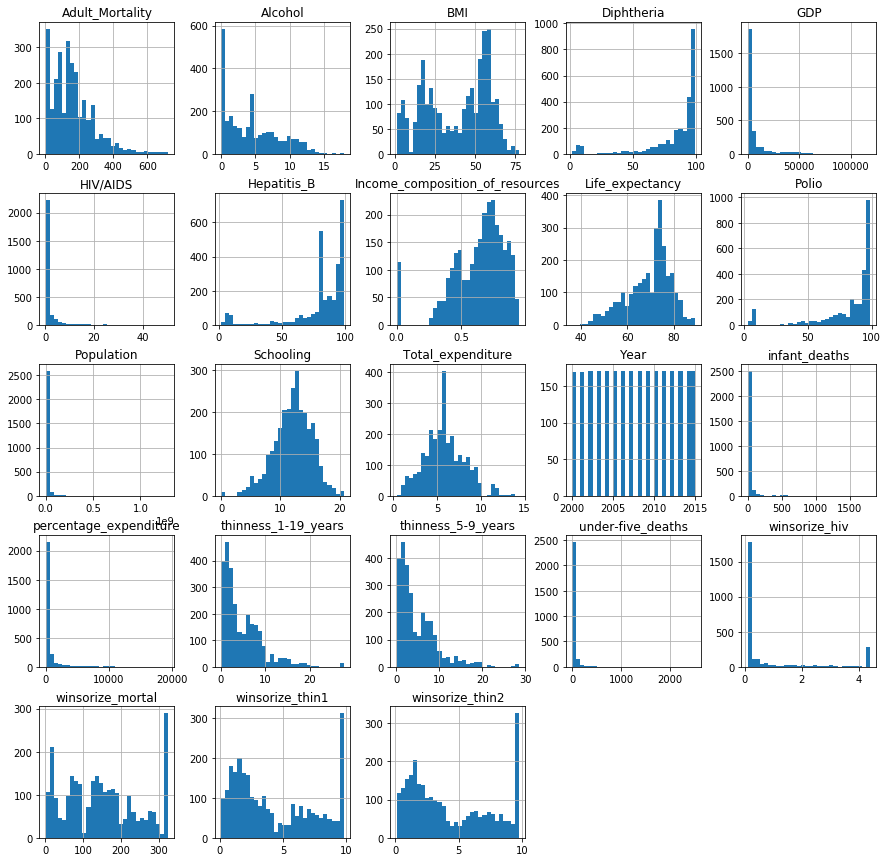

In [32]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_df = life_df.select_dtypes(include=numerics)
numeric_df.hist(bins=30, figsize=(15, 15))
plt.show()

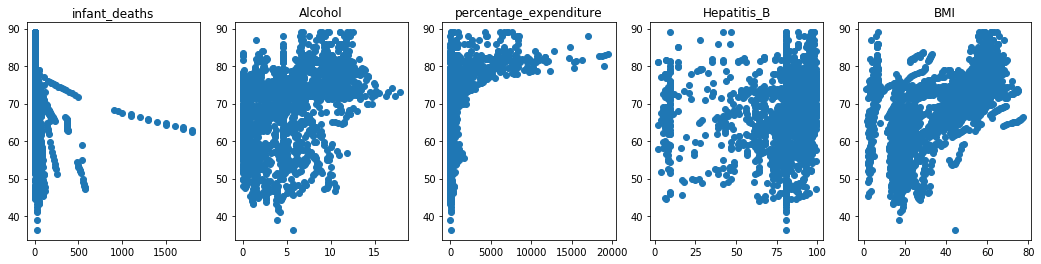

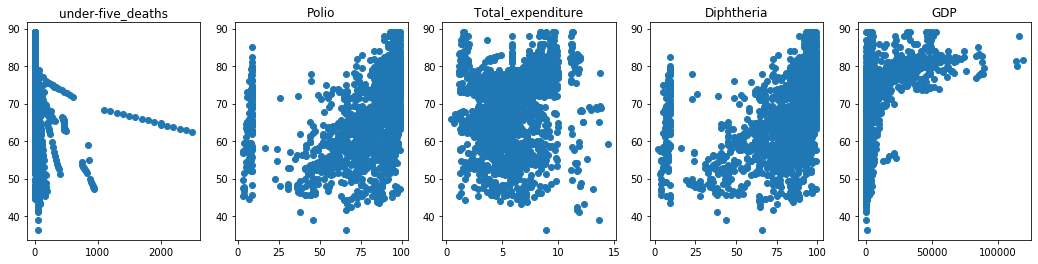

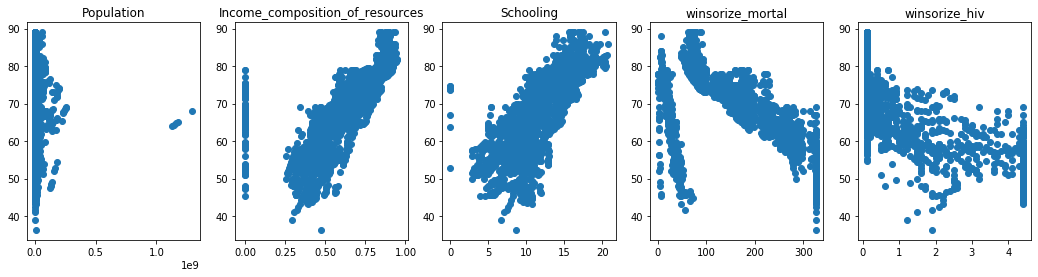

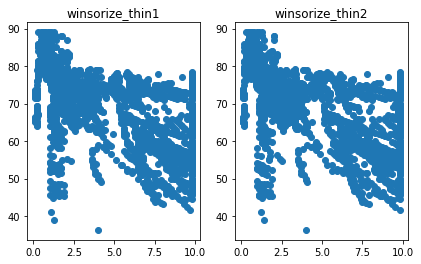

In [33]:
cols = ['infant_deaths', 'Alcohol', 'percentage_expenditure', 'Hepatitis_B',
       'BMI', 'under-five_deaths', 'Polio', 'Total_expenditure', 'Diphtheria', 
       'GDP', 'Population', 'Income_composition_of_resources', 'Schooling',
       'winsorize_mortal', 'winsorize_hiv', 'winsorize_thin1',
       'winsorize_thin2']

x = 1
plt.figure(figsize=(18,4))
for col in cols:
    plt.subplot(1,5,x)
    plt.scatter(life_df[col], life_df["Life_expectancy"])
    plt.title(col)
    
    if (x == 5):
        x = 1
        plt.show()
        plt.figure(figsize=(18,4))
    else:
        x += 1

## 4) In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

## Correlation matrix

In [34]:
corrmat_life = life_df.corr()
corrmat_life

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,BMI,under-five_deaths,Polio,...,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling,winsorize_mortal,winsorize_hiv,winsorize_thin1,winsorize_thin2
Year,1.000000,0.171849,-0.076750,-0.038159,-0.048165,0.032816,0.094964,0.102398,-0.043172,0.086612,...,0.094518,0.014092,-0.040190,-0.044173,0.239247,0.212443,-0.049209,-0.098088,-0.032856,-0.031943
Life_expectancy,0.171849,1.000000,-0.680764,-0.180231,0.371451,0.395429,0.192314,0.563037,-0.205310,0.453068,...,0.444556,-0.034827,-0.463555,-0.458385,0.726189,0.760373,-0.631279,-0.765706,-0.575212,-0.575876
Adult_Mortality,-0.076750,-0.680764,1.000000,0.063620,-0.166224,-0.246019,-0.124638,-0.374743,0.077940,-0.256823,...,-0.285584,-0.001629,0.289017,0.295537,-0.451037,-0.447893,0.946241,0.589892,0.380052,0.389360
infant_deaths,-0.038159,-0.180231,0.063620,1.000000,-0.102489,-0.083562,-0.174299,-0.219491,0.996626,-0.162548,...,-0.098680,0.559559,0.464477,0.470819,-0.149335,-0.204670,0.070832,0.083718,0.230346,0.230897
Alcohol,-0.048165,0.371451,-0.166224,-0.102489,1.000000,0.362857,0.057453,0.315428,-0.098057,0.194549,...,0.333187,-0.024192,-0.408038,-0.396000,0.438024,0.532384,-0.189899,-0.117732,-0.446170,-0.435750
percentage_expenditure,0.032816,0.395429,-0.246019,-0.083562,0.362857,1.000000,0.011928,0.235102,-0.085495,0.150473,...,0.900770,-0.020413,-0.260341,-0.262482,0.385364,0.400079,-0.274493,-0.174753,-0.308660,-0.315514
Hepatitis_B,0.094964,0.192314,-0.124638,-0.174299,0.057453,0.011928,1.000000,0.134098,-0.179889,0.416320,...,0.059657,-0.126129,-0.100062,-0.105926,0.158209,0.174771,-0.120407,-0.161927,-0.071383,-0.081594
BMI,0.102398,0.563037,-0.374743,-0.219491,0.315428,0.235102,0.134098,1.000000,-0.229184,0.278410,...,0.282102,-0.075115,-0.531129,-0.539217,0.515526,0.568202,-0.385979,-0.437023,-0.569378,-0.582280
under-five_deaths,-0.043172,-0.205310,0.077940,0.996626,-0.098057,-0.085495,-0.179889,-0.229184,1.000000,-0.179896,...,-0.101477,0.547576,0.465708,0.470958,-0.167384,-0.220212,0.083850,0.112660,0.240682,0.240388
Polio,0.086612,0.453068,-0.256823,-0.162548,0.194549,0.150473,0.416320,0.278410,-0.179896,1.000000,...,0.194710,-0.049407,-0.209903,-0.212072,0.379079,0.413361,-0.265527,-0.362669,-0.231517,-0.234094


## Heat map

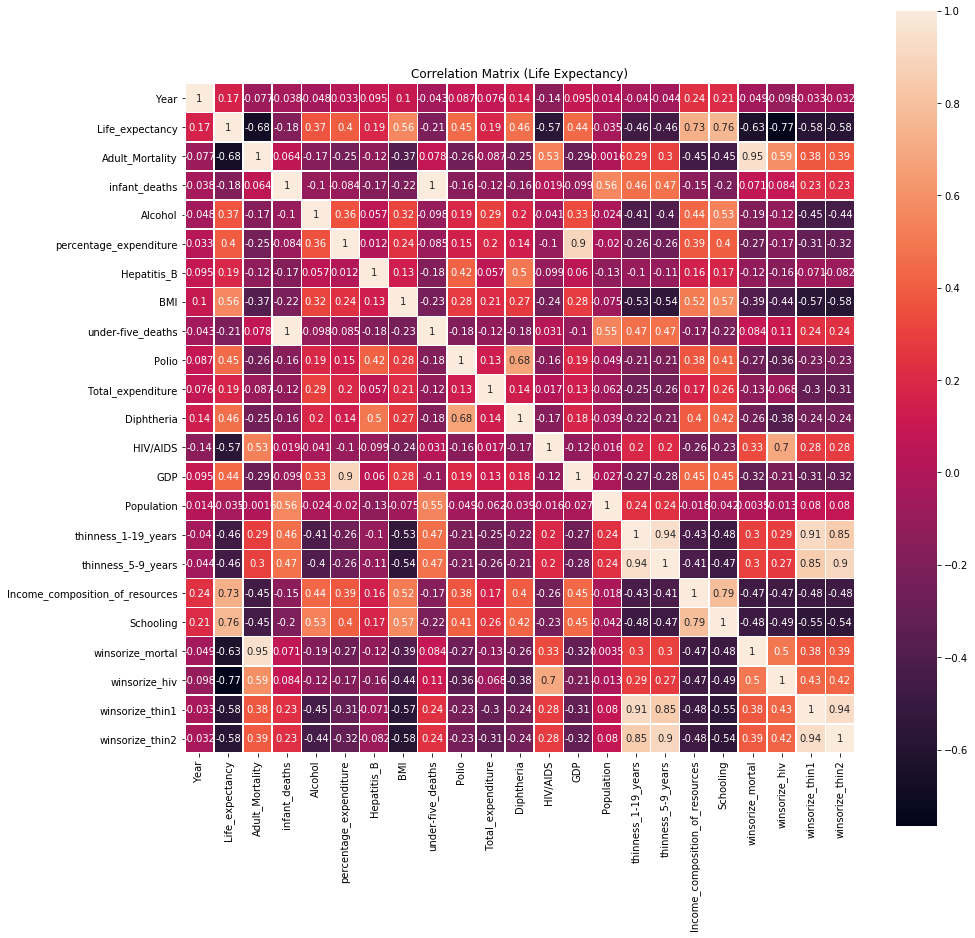

In [35]:
corrmap_life = life_df.corr()

plt.figure(figsize=(15, 15))

sns.heatmap(corrmat_life, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix (Life Expectancy)")

plt.show()

## Based on the correlation matrix and heatmap, I will choose these variables for the model
* winsorize_hiv (HIV/AIDS)
* winsorize_thin1 (thinness_1-19_years)	
* Schooling
* BMI
* Income_composition_of_resources

In [36]:
model_cols = ['winsorize_hiv', 'winsorize_thin1', 'Schooling', 'BMI', 'Income_composition_of_resources']

## Remove zero value rows

In [37]:
life_df = life_df[life_df['winsorize_hiv'] != 0]
life_df = life_df[life_df['winsorize_thin1'] != 0]
life_df = life_df[life_df['Schooling'] != 0]
life_df = life_df[life_df['BMI'] != 0]
life_df = life_df[life_df['Income_composition_of_resources'] != 0]
life_df.shape

(2614, 25)

[]

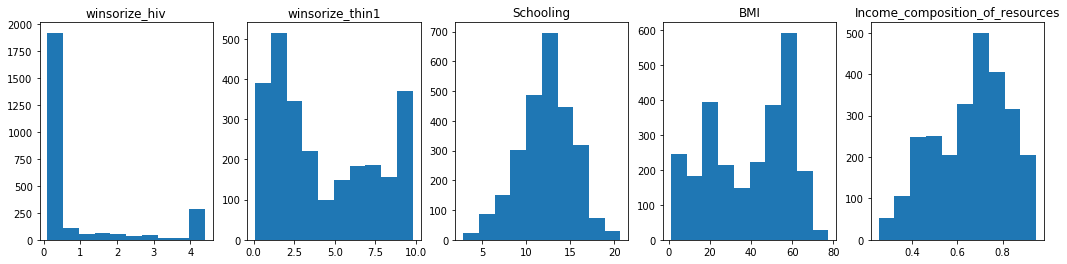

In [38]:
plt.figure(figsize=(18,4))

x = 1
for col in model_cols:
    plt.subplot(1,5,x)
    plt.hist(life_df[col])
    plt.title(col)
    x += 1

plt.plot()

In [39]:
for col in model_cols:
    jb_stats = jarque_bera(np.log(life_df[col]))
    norm_stats = normaltest(np.log(life_df[col]))

    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 517.8113680674824 and p value is 0.0
Normality test statistics is 398.0163980312397 and p value is 3.731103650944566e-87
Jarque-Bera test statistics is 272.8791431199529 and p value is 0.0
Normality test statistics is 217.78623751178557 and p value is 5.1088059509534927e-48
Jarque-Bera test statistics is 1340.2274690389027 and p value is 0.0
Normality test statistics is 589.5643019939761 and p value is 9.500324911610729e-129
Jarque-Bera test statistics is 1220.0083795747607 and p value is 0.0
Normality test statistics is 625.6677643972416 and p value is 1.3739508869307438e-136
Jarque-Bera test statistics is 318.2946118531531 and p value is 0.0
Normality test statistics is 244.56611436036738 and p value is 7.818852788009245e-54


## Covariance matrix

In [41]:
life_df = life_df.drop(columns = ['Country', 'Year', 'Status'])

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(life_df)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00038270e+00 -6.93506469e-01 -1.70711406e-01  3.73395858e-01
   3.96989550e-01  1.99216629e-01  5.63191363e-01 -1.93831776e-01
   4.53356960e-01  1.78168636e-01  4.63795010e-01 -5.75758865e-01
   4.45202267e-01 -3.35419263e-02 -4.67181620e-01 -4.63865036e-01
   8.88432503e-01  7.79092647e-01 -6.44393629e-01 -7.67910516e-01
  -5.81620054e-01 -5.83951332e-01]
 [-6.93506469e-01  1.00038270e+00  7.11239062e-02 -1.63701229e-01
  -2.47925962e-01 -1.33472050e-01 -3.78692817e-01  8.72111629e-02
  -2.71132925e-01 -8.21375928e-02 -2.64250341e-01  5.44661032e-01
  -2.87417874e-01  2.35443277e-04  2.96796257e-01  3.05019709e-01
  -5.69834304e-01 -4.60106190e-01  9.46130992e-01  6.12868086e-01
   3.91652265e-01  4.02766131e-01]
 [-1.70711406e-01  7.11239062e-02  1.00038270e+00 -1.16390650e-01
  -8.48047238e-02 -1.79891375e-01 -2.21533782e-01  9.97611391e-01
  -1.54574735e-01 -1.20008627e-01 -1.56697774e-01  1.25888103e-02
  -9.98958786e-02  5.61577864e-01  4.72286300e-01  4

## Calculating and inspecting eigenvalues and eigenvectors

In [42]:
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[-0.29816458  0.22476035  0.1284606  -0.18132357 -0.16739196 -0.09142619
 -0.23947017  0.1338704  -0.16797722 -0.10731219 -0.17121715  0.15475476
 -0.18074683  0.0559253   0.26397802  0.26374384 -0.30442634 -0.28427706
  0.22251113  0.2254591   0.28032526  0.28124948]
Eigenvalue 1: 8.440981456952164
----------------------------------------
Eigenvector 2: 
[ 0.1902508  -0.25632541  0.44045069 -0.05182913  0.05630749 -0.00409768
 -0.01540302  0.43033285  0.08806059 -0.09932338  0.08666964 -0.2339408
  0.07265475  0.3488116   0.27065849  0.27223631  0.11974217  0.06874777
 -0.22363808 -0.25182024  0.11511683  0.11352345]
Eigenvalue 2: 2.7974319178173164
----------------------------------------
Eigenvector 3: 
[-0.07930269  0.11614379  0.27196924  0.24304324  0.26566394 -0.38836526
  0.03931999  0.28039704 -0.31828481  0.14483429 -0.33844938  0.15004386
  0.22182092  0.23560275 -0.14578257 -0.14136875  0.0034853   0.03150259
  0.08121101  0.18210382 -0.22391169 -0.22230322]

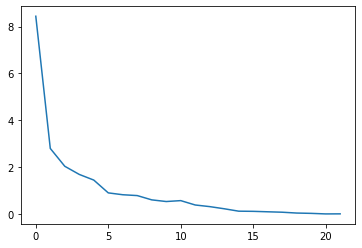

[8.44098146e+00 2.79743192e+00 2.03607961e+00 1.68809923e+00
 1.44721983e+00 9.00170850e-01 8.20993837e-01 7.84876249e-01
 6.01900435e-01 5.30980646e-01 5.69868776e-01 3.83168852e-01
 3.13782326e-01 2.22084527e-01 1.19080183e-01 1.12125820e-01
 9.31743217e-02 7.46396037e-02 3.90903066e-02 2.55883179e-02
 2.15411186e-03 4.92823653e-03]


In [44]:
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.3835342  0.12710735 0.09251367 0.07670243 0.06575755]


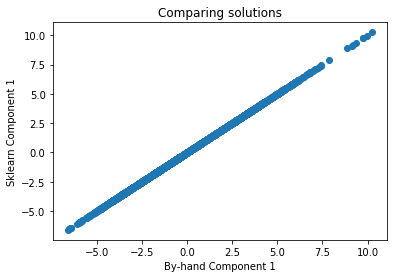

In [45]:
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

## 5) Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

Cleared missing values via removing them or using the mean(), or replacing with zeros

Overview of Countries, Years and Status (developing, not developing)

Outlier analysis, winsorized to deal with the outliers

Visualized continuous variables, looked at correlation matrix and heat map

Based on the correlation matrix and heatmap, I will choose these variables for the model
winsorize_hiv (HIV/AIDS)
winsorize_thin1 (thinness_1-19_years)
Schooling
BMI
Income_composition_of_resources

Normality on the above variables

Standarized data, PCA

